# **NEURAL STYLE TRANSFER**

*   Imported torch for the implementation.
*   Imported PIL to manipulate the images
*   Imported matplotlib to display graphs and images
*   Imported numpy to manipulate the image matrix





In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
cd /content/gdrive/My Drive/NeuralStyleTrans

/content/gdrive/My Drive/NeuralStyleTrans


In [18]:
%ls

japnese_garden.jpg  starry_night_full.jpg


In [20]:
#Convert image to tensors
to_tensor = tv.transforms.Compose([
                tv.transforms.Resize((512,512)),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[1, 1, 1]),
            ])
#Convert tensor to readable form
unload = tv.transforms.Compose([
                tv.transforms.Normalize(mean=[-0.485,-0.456,-0.406],
                                    std=[1,1,1]),                
                tv.transforms.Lambda(lambda x: x.clamp(0,1))
                ])
#Convert it to image to display
to_image = tv.transforms.ToPILImage()

#Uploading the images from PC
# uploaded = files.upload()
input_image = Image.open('japanese_garden.jpg')
style_image = Image.open('starry_night_full.jpg')
#Converting the images to tensors
style_img = to_tensor(style_image).to(device)
input_img = to_tensor(input_image).to(device)

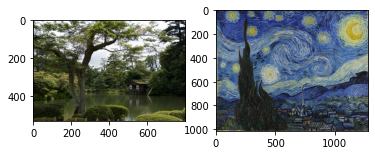

In [21]:
# Viewing the input images
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow((input_image),label = "Content")
ax2.imshow((style_image),label = "Style")
plt.show()

In [22]:
#Appending the desired features into a feature matrix
def get_features(module, x, y):
    features.append(y)
#Function to calculate the gram matrix   
def gram_matrix(x):  
    b, c, h, w = x.size()
    F = x.view(b,c,h*w)
    G = torch.bmm(F, F.transpose(1,2))/(h*w)
    return G

In [23]:
 #Function calculating gram loss when given the gram_matrices of the input style image features and the style features of the final image
 def gram_loss(gram_targets, style_features):
      gram_styles = [gram_matrix(i) for i in style_features] #For the desired image
      loss = 0
      for i in range(5):
            n_c = gram_styles[i].shape[0]
            loss += beta * mse_loss(gram_styles[i],gram_targets[i])/(n_c**2)
      return loss

In [24]:
# Variation loss makes the images smoother, defined over spatial dimensions
def var_loss(image):
      loss = torch.mean(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) + \
          torch.mean(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))
      return loss

In [25]:
VGG = tv.models.vgg19(pretrained=True).features
VGG.to(device)

#Etracting the features for content and style from the model, and using average pool for all layers, as given in the paper Gatys et. al.
for i, layer in enumerate(VGG):    
    if i in [0,5,10,19,21,28]:
        VGG[i].register_forward_hook(get_features)   
    elif isinstance(layer, nn.MaxPool2d):
        VGG[i] = nn.AvgPool2d(kernel_size=2)

VGG.eval()

for p in VGG.parameters():
    p.requires_grad = False
# 21 corresponds to the layer 4-2 which contains the content information/target to be reached 
features = []
VGG(input_img.unsqueeze(0))
content_target = features[4].detach()
# 0,5,10,19,28 correspond to 1-1, 2-1, 3-1, 4-1, 5-1 layers which contain the style information
features = []
VGG(style_img.unsqueeze(0))
style_targets = features[:4]+features[5:]
gram_targets = [gram_matrix(i).detach() for i in style_targets]


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [26]:
alpha = 1e2
beta = 1e3
gamma = 1
iterations = 15
# image = input_img.clone().unsqueeze(0)                  # Using the input-like image directly 
image = torch.randn(1,3,512,512).to(device)           # Using a random noise image
images = []
optimizer = optim.LBFGS([                               # Using the LBFGS optimizer as it gives good results
image.requires_grad_()], lr=1)    
mse_loss = nn.MSELoss(reduction='mean')
total_content_loss = []
total_style_loss = []
total_variation_loss = []

In [27]:
for itr in range(iterations):

    features = []
    def closure():
          optimizer.zero_grad()
          VGG(image)
          #New features are getting added and we only need to consider the latest ones
          image_features = features[-6:]
          content_features = image_features[4]
          style_features = image_features[:4]+image_features[5:]

          # Once the features are extracted, they are discarded for the next iteration
          image_features = []

          # Calculating losses
          content_loss = alpha * mse_loss(content_features, content_target)
          style_loss = gram_loss(gram_targets, style_features)
          variation_loss = gamma*var_loss(image)

          total_loss = content_loss + style_loss + variation_loss

          total_content_loss.append(content_loss)
          total_style_loss.append(style_loss)
          total_variation_loss.append(variation_loss)

          #Backpropogation
          total_loss.backward()
          return total_loss


    optimizer.step(closure)    
    print('Step {}: S_loss: {:.8f} C_loss: {:.8f} V_loss: {:.8f}'.format(itr, total_style_loss[-1], total_content_loss[-1], total_variation_loss[-1]))
    

    if itr%1 == 0:
        temp = unload(image[0].cpu().detach())
        temp = to_image(temp)
        temp = np.array(temp)
        images.append(temp)

final_image = images[-1]
# Saving the output image
plt.imsave('last.jpg',final_image)

Step 0: S_loss: 10.40487289 C_loss: 9.54259968 V_loss: 1.68149853
Step 1: S_loss: 4.19830942 C_loss: 5.76390362 V_loss: 1.59044755
Step 2: S_loss: 3.13274407 C_loss: 4.56198168 V_loss: 1.51972628
Step 3: S_loss: 2.59439850 C_loss: 4.02378368 V_loss: 1.45445120
Step 4: S_loss: 2.32544947 C_loss: 3.70192409 V_loss: 1.39263415
Step 5: S_loss: 2.17233276 C_loss: 3.50379896 V_loss: 1.33269358
Step 6: S_loss: 2.06407547 C_loss: 3.36846328 V_loss: 1.27524304
Step 7: S_loss: 1.99409485 C_loss: 3.26948810 V_loss: 1.22029519
Step 8: S_loss: 1.94749725 C_loss: 3.19347835 V_loss: 1.16651344
Step 9: S_loss: 1.91014099 C_loss: 3.14013505 V_loss: 1.11573780
Step 10: S_loss: 1.88709521 C_loss: 3.08717394 V_loss: 1.05619049
Step 11: S_loss: 1.86547375 C_loss: 3.04173684 V_loss: 0.99251223
Step 12: S_loss: 1.85524380 C_loss: 2.99659276 V_loss: 0.92336166
Step 13: S_loss: 1.83841634 C_loss: 2.96952844 V_loss: 0.85488224
Step 14: S_loss: 1.83109236 C_loss: 2.94252038 V_loss: 0.78843570


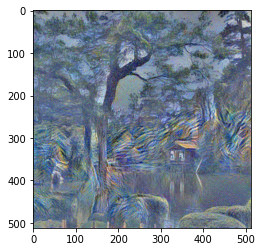

In [28]:
# Displaying the output image
plt.imshow((final_image),label = "Output")
plt.show()